In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from PIL import Image

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dims, lr):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4 , out_channels=16 , kernel_size=7)
        self.conv2 = nn.Conv2d(in_channels=16 , out_channels=8 , kernel_size=8)
        
        self.fc1 = nn.Linear(in_features=8*11*11, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=2)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t ,kernel_size=2 ,stride=2)
        
        t = self.conv2(t)  
        t = F.relu(t)
        t = F.max_pool2d(t ,kernel_size=2 ,stride=2)
        
        t = t.reshape(-1,8*11*11) 
        t = self.fc1(t)
        
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        t = self.fc3(t)
        return t

In [4]:
class Agent():
    def __init__(self, gamma, eps, eps_min, eps_decay, num_actions, device):
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, rate, state, policy_net):
        if random.random() > rate:
            obs = torch.tensor([state], dtype=torch.float32).to(self.device)
            #print(obs.shape)
            return policy_net(obs).argmax(dim=1).item()
        else:
            return np.random.choice(self.num_actions)
        

In [5]:
random.random()

0.014456126487831011

In [6]:
class ReplayMemory():
    def __init__(self, capacity, batch_size, input_dims, eps, eps_min, eps_decay, image_set):
        self.capacity = capacity
        self.batch_size = batch_size
        self.state_memory  = np.zeros((capacity, image_set, 64, 64), dtype=np.float32)
        self.action_memory = np.zeros(capacity, dtype=np.int32)
        self.reward_memory = np.zeros(capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((capacity, image_set, 64, 64), dtype=np.float32)
        self.terminal_memory = np.zeros(capacity, dtype=np.bool)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.experience_ctr = 0
        self.image_set = image_set
        
    def store(self, state, action, reward, next_state, terminal):
        index = self.experience_ctr % self.capacity
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = terminal
        self.experience_ctr += 1
        
    def can_provide_batch(self):
        return self.experience_ctr >= batch_size
    
    def give_batch(self):
        length = min(self.experience_ctr, self.capacity)
        batch = np.random.choice(length, self.batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]
        return (states, actions, rewards, next_states, terminals)
    
    def get_epsilon(self):
        #print(self.experience_ctr)
        rate = self.eps_min + (self.eps - self.eps_min) * math.exp(-1. * self.experience_ctr / self.eps_decay)
        return rate
    
    def rgb2gray(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    
    def preprocess(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        im = Image.fromarray(gray)
        im = im.resize((64,64)) 
        gray = np.array(im)
        return gray
    
    def first_visit(self, image):
        gray_image = self.preprocess(image)
        gray_set = []
        for _ in range(self.image_set):
            gray_set.append(gray_image)
        gray_set = np.array(gray_set)
        #print(gray_set.shape)
        #gray_set = np.rollaxis(gray_set ,2)
        #print(gray_set.shape)
        return gray_set
    
    def next_stack(self, action, image_set, env):
        reward_total = 0
        gray_set = []
        terminal = False
        for _ in range(image_set):
            if terminal==False:
                next_state, reward, terminal, emp = env.step(action)
                reward_total += reward
            image = env.render(mode = 'rgb_array')/255
            #env.close()
            gray_image = self.preprocess(image)
            gray_set.append(gray_image)
        gray_set = np.array(gray_set)
        #gray_set = np.rollaxis(gray_set ,2)
        return gray_set, reward_total, terminal, emp
        

In [17]:
batch_size = 128
gamma = 0.99
eps = 0.9
eps_min = 0.05
eps_decay = 1000
update_rate = 10
capacity = 100000
lr = 0.001
input_dims = 4
num_episodes = 2000
image_set = 4
num_actions = 2

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
policy_net = DQN(input_dims, lr).to(device)
target_net = DQN(input_dims, lr).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=968, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (loss): MSELoss()
)

In [20]:
agent = Agent(gamma, eps, eps_min, eps_decay, num_actions, device)
memory = ReplayMemory(capacity, batch_size, 4, eps, eps_min, eps_decay, image_set)

/tmp/ipykernel_7023/2994347657.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(capacity, dtype=np.bool)


In [21]:
env = gym.make('CartPole-v0')
print(env.observation_space)
env.action_space
#env.reset()

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


Discrete(2)

In [22]:
def get_tensors(batch, device):
    states = torch.tensor(batch[0]).to(device)
    actions = batch[1]
    rewards = torch.tensor(batch[2]).to(device)
    next_states = torch.tensor(batch[3]).to(device)
    dones = torch.tensor(batch[4]).to(device)
    return states, actions, rewards, next_states, dones

In [23]:
score_track = []
eps_track = []
loss_track = []
batch_index = np.arange(batch_size, dtype = np.int32)
for episode in range(num_episodes):
    print('episode : ', episode, end='\t\t')
    score = 0
    terminal = False
    env.reset()
    image = env.render(mode = 'rgb_array')/255
    #env.close()
    state = memory.first_visit(image)
    while not terminal:
        rate = memory.get_epsilon()
        #print(rate)
        eps_track.append(rate)
        action = agent.select_action(rate, state, policy_net)
        next_state, reward, terminal, emp = memory.next_stack(action, image_set, env)
        #next_state, reward, terminal, emp = env.step(action)
        memory.store(state, action, reward, next_state, terminal)
        state = next_state.copy()
        score += reward
        
        if memory.can_provide_batch():
            batch = memory.give_batch()
            states, actions, rewards, next_states, dones = get_tensors(batch, device)
            
            current_q_values = policy_net.forward(states)[batch_index, actions]
            current_q_values = current_q_values.reshape(-1,1)
            next_q_values = target_net.forward(next_states)
            next_q_values[dones] = 0.0
            next_q_values = torch.max(next_q_values, dim=1)[0].detach()
            
            target_q_values = (gamma * next_q_values) + rewards
            target_q_values = target_q_values.reshape(-1,1)
            #print(current_q_values.shape, next_q_values.shape, rewards.shape)
            policy_net.optimizer.zero_grad()
            loss = policy_net.loss(target_q_values, current_q_values)
            loss_track.append(loss.item())
            loss.backward()
            policy_net.optimizer.step()
            
    score_track.append(score)
    print('score : ', score, end='\t\t')
    print('avg_score : ', np.mean(score_track[-50:]))
    if episode%update_rate==0:
        target_net.load_state_dict(policy_net.state_dict())
env.close()

episode :  0		score :  16.0		avg_score :  16.0
episode :  1		score :  10.0		avg_score :  13.0
episode :  2		score :  8.0		avg_score :  11.333333333333334
episode :  3		score :  22.0		avg_score :  14.0
episode :  4		score :  10.0		avg_score :  13.2
episode :  5		score :  10.0		avg_score :  12.666666666666666
episode :  6		score :  12.0		avg_score :  12.571428571428571
episode :  7		score :  9.0		avg_score :  12.125
episode :  8		score :  24.0		avg_score :  13.444444444444445
episode :  9		score :  19.0		avg_score :  14.0
episode :  10		score :  9.0		avg_score :  13.545454545454545
episode :  11		score :  27.0		avg_score :  14.666666666666666
episode :  12		score :  28.0		avg_score :  15.692307692307692
episode :  13		score :  9.0		avg_score :  15.214285714285714
episode :  14		score :  20.0		avg_score :  15.533333333333333
episode :  15		score :  9.0		avg_score :  15.125
episode :  16		score :  9.0		avg_score :  14.764705882352942
episode :  17		score :  8.0		avg_score :  14.38888888888

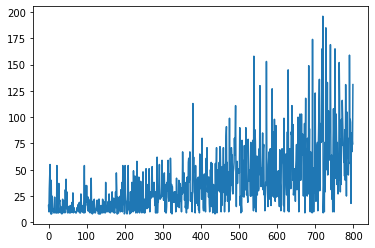

In [14]:
x = range(len(score_track))
plt.plot(x, score_track)

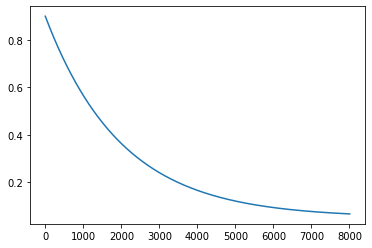

In [15]:
x = range(len(eps_track))
plt.plot(x, eps_track)

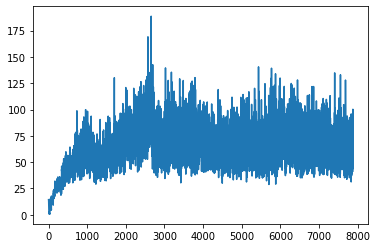

In [16]:
x = range(len(loss_track))
plt.plot(x, loss_track)

In [ ]:
state = env.reset()
score = 0
done = False
avg_score = []
avg_score_track = []
for i in range(20):
    score = 0
    terminal = False
    env.reset()
    image = env.render(mode = 'rgb_array')/255
    #env.close()
    state = memory.first_visit(image)
    while not terminal:
        rate = memory.get_epsilon()
        #print(rate)
        eps_track.append(rate)
        action = agent.select_action(0, state, policy_net)
        next_state, reward, terminal, emp = memory.next_stack(action, image_set, env)
        #next_state, reward, terminal, emp = env.step(action)
        #memory.store(state, action, reward, next_state, terminal)
        state = next_state.copy()
        score += reward
    
    avg_score.append(score)
env.close()
print(np.mean(avg_score))    
#a = torch.tensor([[1,2,3,4], [1,1,1,1]], dtype=torch.float32).to(device)
#b = policy_net(a)
#print(b, b.shape)

69.0
